In [1]:
import h5py
# from deeprankCore.Data import save_hdf5_keys
import torch
from models import CnnClassificationBaseline
from deeprank.learn import DataSet, NeuralNet
import torch.utils.data as data_utils
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from typing import List

import torch.nn.functional as F

In [2]:
# Copied from deeprankcore.Dataset to avoid having to install that

def save_hdf5_keys(
    f_src_path: str,
    src_ids: List[str],
    f_dest_path: str,
    hardcopy = False
    ):
    """Save references to keys in data_ids in a new hdf5 file.
    Parameters
    ----------
    f_src_path : str
        The path to the hdf5 file containing the keys.
    src_ids : List[str]
        Keys to be saved in the new hdf5 file.
        It should be a list containing at least one key.
    f_dest_path : str
        The path to the new hdf5 file.
    hardcopy : bool, default = False
        If False, the new file contains only references.
        (external links, see h5py ExternalLink class) to the original hdf5 file.
        If True, the new file contains a copy of the objects specified in data_ids
        (see h5py HardLink class).
        
    """
    if not all(isinstance(d, str) for d in src_ids):
        raise TypeError("data_ids should be a list containing strings.")

    with h5py.File(f_dest_path,'w') as f_dest, h5py.File(f_src_path,'r') as f_src:
        for key in src_ids:
            if hardcopy:
                f_src.copy(f_src[key],f_dest)
            else:
                f_dest[key] = h5py.ExternalLink(f_src_path, "/" + key)

In [3]:
DATA_PATH = './'
hdf5_path = DATA_PATH + '000_hla_drb1_0101_15mers.hdf5'
sample_path = DATA_PATH + 'one_sample.hdf5'
pretrained_model = 'best_valid_model.pth.tar'

In [4]:
save_hdf5_keys(hdf5_path, ['BA_105966'], sample_path, hardcopy = True)

In [5]:
tst = h5py.File(sample_path, 'r')
print(tst['BA_105966'].keys())
print(tst['BA_105966']['features'].keys())
print(tst['BA_105966']['features']['vdwaals'][:])
print(len(tst['BA_105966']['features'].keys()))

<KeysViewHDF5 ['complex', 'features', 'features_raw', 'grid_points', 'mapped_features', 'targets']>
<KeysViewHDF5 ['Edesolv', 'PSSM_ALA', 'PSSM_ARG', 'PSSM_ASN', 'PSSM_ASP', 'PSSM_CYS', 'PSSM_GLN', 'PSSM_GLU', 'PSSM_GLY', 'PSSM_HIS', 'PSSM_ILE', 'PSSM_LEU', 'PSSM_LYS', 'PSSM_MET', 'PSSM_PHE', 'PSSM_PRO', 'PSSM_SER', 'PSSM_THR', 'PSSM_TRP', 'PSSM_TYR', 'PSSM_VAL', 'RCD_apolar-apolar', 'RCD_apolar-charged', 'RCD_charged-charged', 'RCD_polar-apolar', 'RCD_polar-charged', 'RCD_polar-polar', 'RCD_total', 'bsa', 'charge', 'coulomb', 'vdwaals']>
[[ 0.00000000e+00 -9.04700000e+00 -1.19520000e+01  1.20000000e-01
  -4.78349735e-03]
 [ 0.00000000e+00 -1.04640000e+01 -1.25010000e+01  3.65000000e-01
  -5.74971915e-03]
 [ 0.00000000e+00 -8.99500000e+00 -1.07790000e+01 -8.77000000e-01
  -4.81512589e-02]
 ...
 [ 1.00000000e+00  2.14660000e+01  2.05400000e+00  5.56100000e+00
  -3.83359132e-02]
 [ 1.00000000e+00  2.19640000e+01  2.11300000e+00  6.71900000e+00
  -1.15119041e-02]
 [ 1.00000000e+00  2.1570

In [6]:
model = NeuralNet(sample_path, CnnClassificationBaseline, pretrained_model = pretrained_model, outdir='./out/')
model.test()



=	 DeepRank Data Set
=
=	 Training data
=	 -> ./one_sample.hdf5
=
=
=

   Checking dataset Integrity


   Processing data set:
   Train dataset
 : STD is null for PSSM_ARG_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_CYS_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_GLN_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_GLU_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_HIS_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_ILE_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_MET_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_PHE_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_PRO_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_TRP_chain2 in ./one_sample.hdf5
  Final STD Null for Feature_ind/PSSM_ARG_chain2. Changed it to 1
  Final STD Null for Feature_ind/PSSM_CYS_chain2. Changed it to 1
  Final STD Null for Feature_ind/PSSM_GLN_chain2. Changed it to 1
  Final STD Null for Feature_ind/PSSM_GLU_chain2. Changed it to 1
  Final STD Null for Feature_i

In [7]:
model.data_set.input_shape

(64, 35, 30, 30)

In [8]:
# step by step without using NeuralNet

In [9]:
data_set = DataSet(
    sample_path,
    chain1="M",
    chain2="P",
    process=False)

state = torch.load(pretrained_model,  map_location='cpu')

data_set.select_feature = state['select_feature']
data_set.select_target = state['select_target']

data_set.pair_chain_feature = state['pair_chain_feature']
data_set.dict_filter = state['dict_filter']

data_set.normalize_targets = state['normalize_targets']
if data_set.normalize_targets:
    data_set.target_min = state['target_min']
    data_set.target_max = state['target_max']

data_set.normalize_features = state['normalize_features']
if data_set.normalize_features:
    data_set.feature_mean = state['feature_mean']
    data_set.feature_std = state['feature_std']

data_set.transform = state['transform']
data_set.proj2D = state['proj2D']
data_set.target_ordering = state['target_ordering']
data_set.clip_features = state['clip_features']
data_set.clip_factor = state['clip_factor']
data_set.mapfly = state['mapfly']
data_set.grid_info = state['grid_info']

data_set.process_dataset()



=	 DeepRank Data Set
=
=	 Training data
=	 -> ./one_sample.hdf5
=
=
=

   Checking dataset Integrity


   Processing data set:
   Train dataset
 : STD is null for PSSM_ARG_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_CYS_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_GLN_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_GLU_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_HIS_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_ILE_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_MET_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_PHE_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_PRO_chain2 in ./one_sample.hdf5
 : STD is null for PSSM_TRP_chain2 in ./one_sample.hdf5
  Final STD Null for Feature_ind/PSSM_ARG_chain2. Changed it to 1
  Final STD Null for Feature_ind/PSSM_CYS_chain2. Changed it to 1
  Final STD Null for Feature_ind/PSSM_GLN_chain2. Changed it to 1
  Final STD Null for Feature_ind/PSSM_GLU_chain2. Changed it to 1
  Final STD Null for Feature_i

In [10]:
net = CnnClassificationBaseline(data_set.input_shape)
device = torch.device("cpu")

net.to(device)

if state['cuda']:
    for paramname in list(state['state_dict'].keys()):
        paramname_new = paramname.lstrip('module.')
        if paramname != paramname_new:
            state['state_dict'][paramname_new] = \
                state['state_dict'][paramname]
            del state['state_dict'][paramname]

net.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [11]:
optimizer = optim.SGD(
    net.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.001)
optimizer.load_state_dict(state['optimizer'])

In [12]:
index = list(range(data_set.__len__()))
sampler = data_utils.sampler.SubsetRandomSampler(index)
loader = data_utils.DataLoader(data_set, sampler=sampler)

In [13]:
for idx, data in enumerate(loader):
    print(data['feature'].shape)
    print(data['target'])
    print(data['mol'])

torch.Size([1, 64, 35, 30, 30])
tensor([[0.]])
[('./one_sample.hdf5',), ('BA_105966',)]


In [14]:
net.train(mode=False)
torch.set_grad_enabled(False)

In [15]:
for d in loader:
    inputs = d['feature']
    targets = d['target']
    mol = d['mol']
    inputs, targets = Variable(inputs).float(), Variable(targets).float()
    targets = targets.long()
    print(mol)
    print(inputs.shape)
    print(targets)
    outputs = net(inputs)
    print(outputs)
    print(F.softmax(torch.FloatTensor(outputs), dim=1).data.numpy())
    targets = targets.view(-1)
    print(targets)


[('./one_sample.hdf5',), ('BA_105966',)]
torch.Size([1, 64, 35, 30, 30])
tensor([[0]])
tensor([[ 1.9637, -1.9273]])
[[0.9799851  0.02001488]]
tensor([0])


In [16]:
inputs_toplot = np.squeeze(np.array(inputs))
inputs_toplot.shape


(64, 35, 30, 30)

In [17]:
%time net(inputs)

CPU times: user 60.4 ms, sys: 20.9 ms, total: 81.4 ms
Wall time: 90.3 ms


tensor([[ 1.9637, -1.9273]])

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [19]:
one_vol = inputs_toplot[20, ...]
grid = np.indices(one_vol.shape)
one_vol.min(), one_vol.mean(), one_vol.max(), one_vol.std()

(-27.65683, -2.0345052e-08, 15.937727, 1.0)

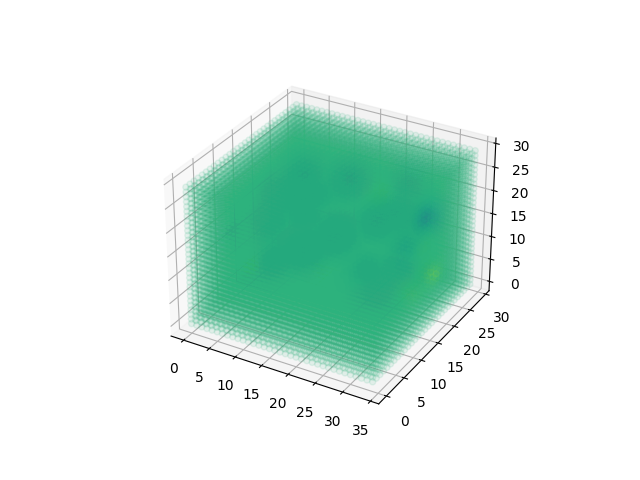

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

one_vol = inputs_toplot[20, ...]
one_vol.shape

alpha = .1 * np.ones_like(one_vol)
ax.scatter3D(*grid, c=one_vol, alpha=alpha)

## Testing DIANNA

In [21]:
def run_model(data_item):
    outputs = net(data_item)
    return F.softmax(torch.FloatTensor(outputs), dim=1).data.numpy()
    

In [22]:
sample = next(iter(loader))
feature = sample['feature']
target = sample['target']

feature_dianna = feature.data.numpy()[0]
print(feature_dianna.shape)
axis_labels = ['channels', 'x', 'y', 'z']

(64, 35, 30, 30)


In [23]:
def prepare_input_data(data):
    return Variable(torch.tensor(data)).float()

In [24]:
import dianna
from dianna.methods.rise import RISEImage

In [34]:
# heatmaps = dianna.explain_image(run_model, feature_dianna, "RISE", axis_labels=axis_labels, preprocess_function=prepare_input_data, p_keep=.4, labels=(0,1))
rise = RISEImage(n_masks=1000, feature_res=8, p_keep=.4,
            axis_labels=axis_labels, preprocess_function=prepare_input_data)

In [35]:
heatmaps = rise.explain(run_model, feature_dianna, labels=(0, 1))

Explaining: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.84s/it]


In [36]:
heatmaps.shape

(2, 35, 30, 30)

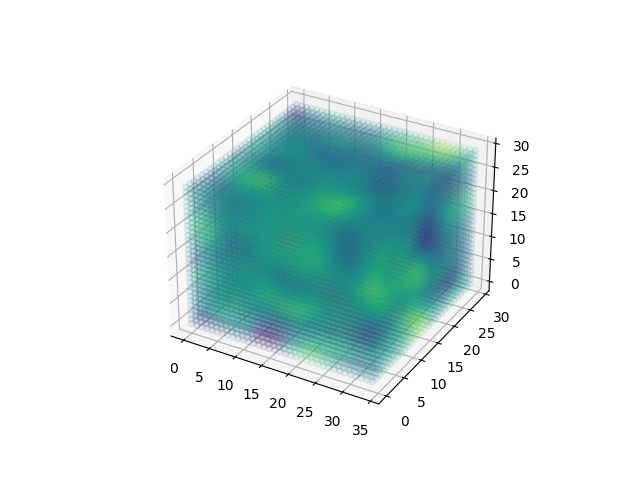

In [37]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*grid, c=heatmaps[0], alpha=.1)

In [40]:
heatmaps[0].min(), heatmaps[0].max()

(0.89297116, 1.0646731)

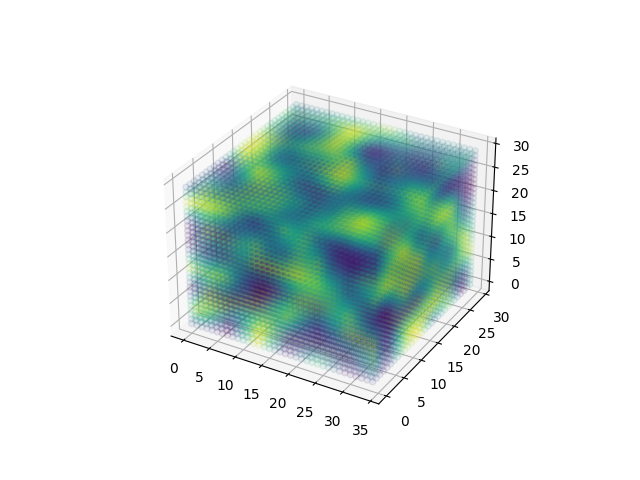

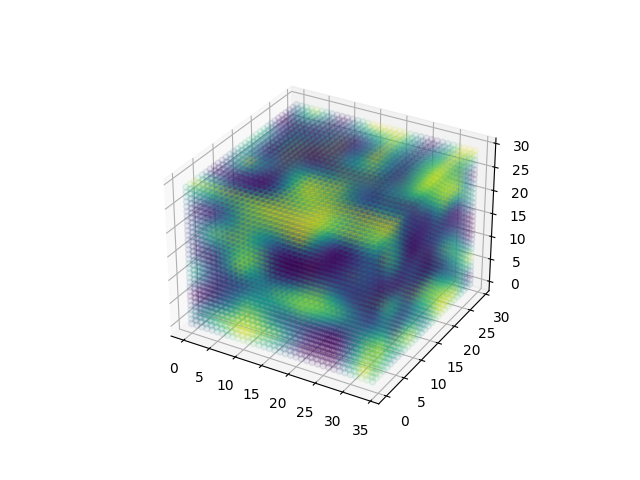

In [33]:
masks = rise.masks[..., 0]
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*grid, c=masks[0], alpha=.1)

plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*grid, c=masks[1], alpha=.1)